### Bibliotecas


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns

### Carregando Dados

In [2]:
df_sf = pd.read_csv(r'D:\Projetos\UFABC\UFABC_Tambra\Dados\SoftFailure_dataset.csv')
df_hd = pd.read_csv(r'D:\Projetos\UFABC\UFABC_Tambra\Dados\HardFailure_dataset.csv')

### Preparação dos dados

#### Junção DFS

In [7]:
# Criando classiicação

df_sf['Base'] =  'SOFT'
df_hd['Base'] = 'HARD'

In [28]:
df_fail = pd.concat([df_sf, df_hd], ignore_index=True)

#### Conversão para datetime

In [29]:
df_fail['Timestamp_s'] = pd.to_datetime(df_fail.Timestamp,unit='s')#[[0]]
df_fail['Timestamp_data'] = df_fail['Timestamp_s'].astype(str).str.split(expand=True)[0]
df_fail['Timestamp_hora'] = df_fail['Timestamp_s'].astype(str).str.split(expand=True)[1]

#### Replice Failure - NaN = 0


In [30]:
df_fail.Failure = df_fail.Failure.replace(np.nan,0).astype(int)

### Interpolação - Tratamento de NaN nas Features Numéricas

In [31]:
# Para dados de série temporal, a interpolação é uma ótima estratégia.
# Ela preenche os valores ausentes com base nos valores vizinhos.
# Primeiro, vamos ordenar o DataFrame pelo tempo para garantir que a interpolação funcione corretamente.
df_fail = df_fail.sort_values(by='Timestamp').reset_index(drop=True)

In [32]:
#### O pandas pode preencher os valores ausentes estimando o que eles deveriam ser com base nos valores vizinhos (anteriores e posteriores).

features_numericas = ['BER', 'OSNR', 'InputPower', 'OutputPower']
df_fail[features_numericas] = df_fail[features_numericas].interpolate(method='linear')

In [33]:
df_fail.InputPower = df_fail.InputPower.replace(np.nan,0)
df_fail.OutputPower = df_fail.OutputPower.replace(np.nan,0)

### Exploração dos dados

In [37]:
df_fail

,Timestamp,Type,ID,BER,OSNR,InputPower,OutputPower,Failure,Timestamp_s,Timestamp_data,Timestamp_hora,Base
0,1623394634,Devices,SPO1/18/11,2.280000e-08,38.500000,0.00,0.00,0,2021-06-11 06:57:14,2021-06-11,06:57:14,HARD
1,1623394635,Devices,SPO2/18/11,8.730000e-07,23.500000,0.00,0.00,0,2021-06-11 06:57:15,2021-06-11,06:57:15,HARD
2,1623394635,Infrastructure,Ampli4,7.303667e-07,26.016667,-22.90,0.70,0,2021-06-11 06:57:15,2021-06-11,06:57:15,HARD
3,1623394635,Infrastructure,Ampli3,5.877333e-07,28.533333,-16.70,0.80,0,2021-06-11 06:57:15,2021-06-11,06:57:15,HARD
4,1623394635,Infrastructure,Ampli2,4.451000e-07,31.050000,-15.50,0.40,0,2021-06-11 06:57:15,2021-06-11,06:57:15,HARD
...,...,...,...,...,...,...,...,...,...,...,...,...
119425,1624486451,Infrastructure,Ampli4,7.306667e-08,34.300000,-22.90,0.70,0,2021-06-23 22:14:11,2021-06-23,22:14:11,SOFT
119426,1624486451,Infrastructure,Ampli1,1.215333e-07,30.000000,-19.20,0.70,0,2021-06-23 22:14:11,2021-06-23,22:14:11,SOFT
119427,1624486451,Devices,SPO2/18/11,1.700000e-07,25.700000,-17.95,0.75,0,2021-06-23 22:14:11,2021-06-23,22:14:11,SOFT
119428,1624486451,Infrastructure,Ampli3,1.700000e-07,25.700000,-16.70,0.80,0,2021-06-23 22:14:11,2021-06-23,22:14:11,SOFT


In [38]:
df_fail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119430 entries, 0 to 119429
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       119430 non-null  int64         
 1   Type            119430 non-null  object        
 2   ID              119430 non-null  object        
 3   BER             119430 non-null  float64       
 4   OSNR            119430 non-null  float64       
 5   InputPower      119430 non-null  float64       
 6   OutputPower     119430 non-null  float64       
 7   Failure         119430 non-null  int64         
 8   Timestamp_s     119430 non-null  datetime64[ns]
 9   Timestamp_data  119430 non-null  object        
 10  Timestamp_hora  119430 non-null  object        
 11  Base            119430 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 10.9+ MB


In [39]:
df_fail.describe()

,Timestamp,BER,OSNR,InputPower,OutputPower,Failure,Timestamp_s
count,1.194300e+05,1.194300e+05,119430.000000,119430.000000,119430.000000,119430.000000,119430
mean,1.623889e+09,1.846473e-04,30.590290,-19.582524,0.648359,0.063728,2021-06-17 00:14:02.432923136
min,1.623395e+09,0.000000e+00,0.000000,-38.000000,0.000000,0.000000,2021-06-11 06:57:14
25%,1.623411e+09,2.370000e-08,25.400000,-22.900000,0.550000,0.000000,2021-06-11 11:24:37
50%,1.623427e+09,1.747500e-07,31.000000,-19.200000,0.700000,0.000000,2021-06-11 15:58:39
75%,1.624470e+09,6.166938e-07,38.500000,-16.700000,0.700000,0.000000,2021-06-23 17:46:46
max,1.624486e+09,2.651316e-02,38.600000,0.000000,0.900000,1.000000,2021-06-23 22:14:11
std,5.271721e+05,1.212574e-03,6.921175,3.740281,0.132266,0.244268,NaN


In [41]:
df_fail.Type.unique()

array(['Devices', 'Infrastructure'], dtype=object)

In [45]:
df_fail.ID.unique()

array(['SPO1/18/11', 'SPO2/18/11', 'Ampli4', 'Ampli3', 'Ampli2', 'Ampli1'],
      dtype=object)

In [40]:
df_fail.corr(numeric_only=True)

,Timestamp,BER,OSNR,InputPower,OutputPower,Failure
Timestamp,1.000000,-0.129228,0.131924,0.139648,0.015441,0.121965
BER,-0.129228,1.000000,-0.260976,-0.064315,-0.016382,-0.020029
OSNR,0.131924,-0.260976,1.000000,0.059078,-0.004025,-0.132893
InputPower,0.139648,-0.064315,0.059078,1.000000,-0.395968,-0.154167
OutputPower,0.015441,-0.016382,-0.004025,-0.395968,1.000000,-0.041835
Failure,0.121965,-0.020029,-0.132893,-0.154167,-0.041835,1.000000


<Axes: >

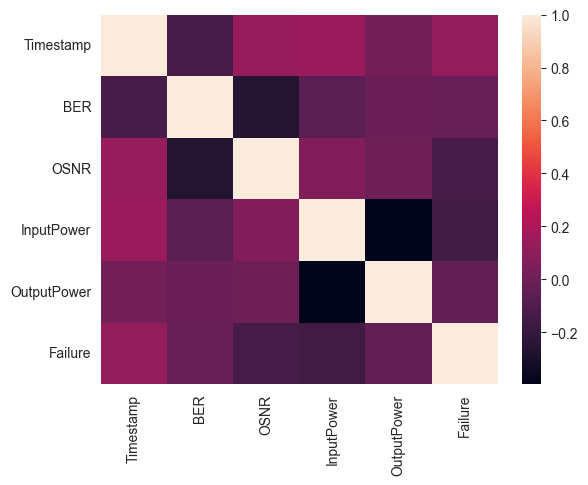

In [42]:
sns.heatmap(df_fail.corr(numeric_only=True))

### Engenharia de Features

#### 1. Features de Janela Deslizante (Rolling Window)

In [47]:
# Vamos criar features que representam a média, desvio padrão, mínimo e máximo dos sensores em diferentes janelas de tempo (5, 15 e 30 períodos).
# Obs: Os cálculos devem ser feitos para cada equipamento (ID) separadamente.

# Garante que os dados estão ordenados por equipamento e tempo
df_feat = df_fail.sort_values(by=['ID', 'Timestamp_s']).copy()

features_to_engineer = ['BER', 'OSNR', 'InputPower', 'OutputPower']
window_sizes = [5, 15, 30]  # Janelas de 5, 15 e 30 períodos

In [48]:
for feature in features_to_engineer:
    for window in window_sizes:
        # Agrupa por ID e aplica a janela deslizante
        rolling_mean = df_feat.groupby('ID')[feature].rolling(window=window, min_periods=1).mean().reset_index(
            drop=True)
        rolling_std = df_feat.groupby('ID')[feature].rolling(window=window, min_periods=1).std().reset_index(drop=True)
        rolling_max = df_feat.groupby('ID')[feature].rolling(window=window, min_periods=1).max().reset_index(drop=True)

        df_feat[f'{feature}_mean_{window}'] = rolling_mean
        df_feat[f'{feature}_std_{window}'] = rolling_std
        df_feat[f'{feature}_max_{window}'] = rolling_max

print("Features de janela deslizante criadas.")

Features de janela deslizante criadas.


#### 2. Features de Atraso (Lag Features)

In [49]:
# Criaremos colunas com os valores dos sensores de 1, 2 e 3 períodos atrás.

lags = [1, 2, 3]

for feature in features_to_engineer:
    for lag in lags:
        # Agrupa por ID e aplica o shift
        df_feat[f'{feature}_lag_{lag}'] = df_feat.groupby('ID')[feature].shift(lag)

print("Features de atraso criadas.")

Features de atraso criadas.


#### 3. Limpeza Final do DataFrame de Features

In [50]:
# A criação de janelas e lags gera valores NaN no início de cada série temporal (por equipamento).
# Vamos remover essas linhas para garantir que o modelo só treine com dados completos.

print(f"Tamanho do DataFrame antes da limpeza de NaN: {df_feat.shape}")

# Remove todas as linhas que contenham qualquer valor NaN gerado
df_feat.dropna(inplace=True)

print(f"Tamanho do DataFrame após a limpeza: {df_feat.shape}")

# Visualizando o resultado final com as novas features
df_feat.head()

Tamanho do DataFrame antes da limpeza de NaN: (119430, 60)
Tamanho do DataFrame após a limpeza: (119407, 60)


,Timestamp,Type,ID,BER,OSNR,InputPower,OutputPower,Failure,Timestamp_s,Timestamp_data,...,BER_lag_3,OSNR_lag_1,OSNR_lag_2,OSNR_lag_3,InputPower_lag_1,InputPower_lag_2,InputPower_lag_3,OutputPower_lag_1,OutputPower_lag_2,OutputPower_lag_3
18,1623394644,Infrastructure,Ampli1,4.413000e-07,30.950000,-23.0,0.7,0,2021-06-11 06:57:24,2021-06-11,...,3.024667e-07,29.440000,36.083333,33.566667,-23.0,-23.0,-23.0,0.7,0.7,0.7
29,1623394647,Infrastructure,Ampli1,4.450000e-07,31.000000,-23.0,0.7,0,2021-06-11 06:57:27,2021-06-11,...,1.598333e-07,30.950000,29.440000,36.083333,-23.0,-23.0,-23.0,0.7,0.7,0.7
33,1623394651,Infrastructure,Ampli1,3.562200e-07,32.580000,-23.0,0.7,0,2021-06-11 06:57:31,2021-06-11,...,5.252800e-07,31.000000,30.950000,29.440000,-23.0,-23.0,-23.0,0.7,0.7,0.7
40,1623394654,Infrastructure,Ampli1,2.993333e-07,33.433333,-23.0,0.7,0,2021-06-11 06:57:34,2021-06-11,...,4.413000e-07,32.580000,31.000000,30.950000,-23.0,-23.0,-23.0,0.7,0.7,0.7
46,1623394657,Infrastructure,Ampli1,2.145000e-08,38.600000,-23.0,0.7,0,2021-06-11 06:57:37,2021-06-11,...,4.450000e-07,33.433333,32.580000,31.000000,-23.0,-23.0,-23.0,0.7,0.7,0.7


#### 4. Features Avançadas

##### a) Features de Tendência (Slope)

In [52]:
# Vamos calcular a inclinação (slope) dos dados dos sensores dentro de uma janela para capturar a tendência de subida ou descida.

# Função para calcular a inclinação (slope) de uma janela
def get_slope(array):
    # polyfit é mais rápido para isso
    y = np.array(array)
    x = np.arange(len(y))
    # O primeiro elemento de polyfit é a inclinação
    slope = np.polyfit(x, y, 1)[0]
    return slope

window_trend = 15  # Janela para cálculo da tendência

for feature in features_to_engineer:
    # Agrupa por ID e aplica a função de slope na janela
    trend = df_feat.groupby('ID')[feature].rolling(window=window_trend, min_periods=window_trend).apply(get_slope,
                                                                                                        raw=True).reset_index(
        drop=True)
    df_feat[f'{feature}_trend_{window_trend}'] = trend

print("Features de tendência criadas.")

Features de tendência criadas.


##### b) Features Cíclicas de Tempo

In [53]:
# Transformar a hora do dia em features de seno e cosseno para que o modelo entenda a natureza cíclica do tempo.

df_feat['hora'] = df_feat['Timestamp_s'].dt.hour
df_feat['hora_sin'] = np.sin(2 * np.pi * df_feat['hora'] / 24.0)
df_feat['hora_cos'] = np.cos(2 * np.pi * df_feat['hora'] / 24.0)
df_feat.drop('hora', axis=1, inplace=True)

print("Features cíclicas de tempo criadas.")

Features cíclicas de tempo criadas.


##### c) Limpeza Final Pós-Features Avançadas


In [54]:
print(f"Tamanho antes da limpeza final: {df_feat.shape}")
df_feat.dropna(inplace=True)
print(f"Tamanho após a limpeza final: {df_feat.shape}")
df_feat.head()

Tamanho antes da limpeza final: (119407, 66)
Tamanho após a limpeza final: (119317, 66)


,Timestamp,Type,ID,BER,OSNR,InputPower,OutputPower,Failure,Timestamp_s,Timestamp_data,...,InputPower_lag_3,OutputPower_lag_1,OutputPower_lag_2,OutputPower_lag_3,BER_trend_15,OSNR_trend_15,InputPower_trend_15,OutputPower_trend_15,hora_sin,hora_cos
18,1623394644,Infrastructure,Ampli1,4.413000e-07,30.950000,-23.0,0.7,0,2021-06-11 06:57:24,2021-06-11,...,-23.0,0.7,0.7,0.7,-6.775825e-09,0.105536,5.911890e-18,9.854771e-18,1.0,6.123234e-17
29,1623394647,Infrastructure,Ampli1,4.450000e-07,31.000000,-23.0,0.7,0,2021-06-11 06:57:27,2021-06-11,...,-23.0,0.7,0.7,0.7,6.694616e-09,-0.129328,5.911890e-18,9.854771e-18,1.0,6.123234e-17
33,1623394651,Infrastructure,Ampli1,3.562200e-07,32.580000,-23.0,0.7,0,2021-06-11 06:57:31,2021-06-11,...,-23.0,0.7,0.7,0.7,2.054693e-08,-0.379338,5.911890e-18,9.854771e-18,1.0,6.123234e-17
40,1623394654,Infrastructure,Ampli1,2.993333e-07,33.433333,-23.0,0.7,0,2021-06-11 06:57:34,2021-06-11,...,-23.0,0.7,0.7,0.7,-9.645964e-09,0.164058,5.911890e-18,9.854771e-18,1.0,6.123234e-17
46,1623394657,Infrastructure,Ampli1,2.145000e-08,38.600000,-23.0,0.7,0,2021-06-11 06:57:37,2021-06-11,...,-23.0,0.7,0.7,0.7,-1.387755e-08,0.270476,5.911890e-18,9.854771e-18,1.0,6.123234e-17


### Etapa 4: Modelagem (Machine Learning)

#### 1. Preparação dos Dados para o Modelo

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [56]:
# Selecionando as features (X) e o alvo (y)
# Vamos remover colunas de identificação, tempo e as features originais dos sensores

features_to_drop = ['Timestamp', 'Type', 'ID', 'Base', 'Timestamp_s', 'Timestamp_data', 'Timestamp_hora',
                    'Failure'] + features_to_engineer

X = df_feat.drop(columns=features_to_drop)
y = df_feat['Failure']

# Divisão em treino e teste (80/20) de forma temporal
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (95453, 54)
Tamanho do conjunto de teste: (23864, 54)


#### 2. Treinamento do Modelo de Baseline (Random Forest)

In [57]:
# Usamos class_weight='balanced' para lidar com o desbalanceamento das classes (poucas falhas)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

print("Iniciando o treinamento do modelo Random Forest...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído.")

Iniciando o treinamento do modelo Random Forest...
Treinamento concluído.


#### 3. Avaliação do Modelo

--- Relatório de Classificação no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21853
           1       0.94      0.31      0.47      2011

    accuracy                           0.94     23864
   macro avg       0.94      0.66      0.72     23864
weighted avg       0.94      0.94      0.93     23864


--- Matriz de Confusão ---


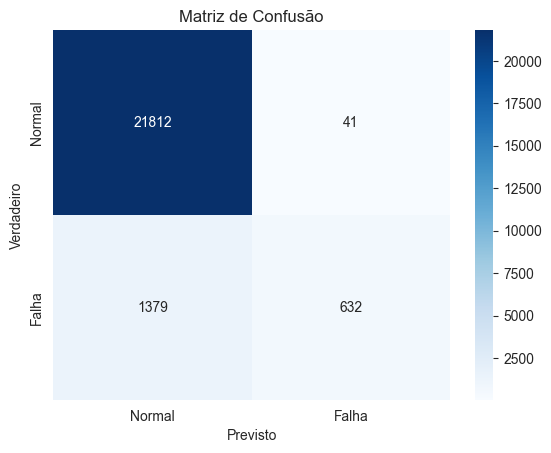

In [58]:
y_pred = rf_model.predict(X_test)

print("--- Relatório de Classificação no Conjunto de Teste ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

### Etapa 5: Avaliação e Interpretabilidade

#### 1. Importância das Features (Feature Importance)

In [59]:
# Agora que temos um modelo treinado, podemos extrair a importância de cada feature.
# Isso nos diz quais variáveis o modelo considerou mais relevantes para fazer as previsões.

importances = rf_model.feature_importances_
feature_names = X_train.columns

# Criando um DataFrame para melhor visualização
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

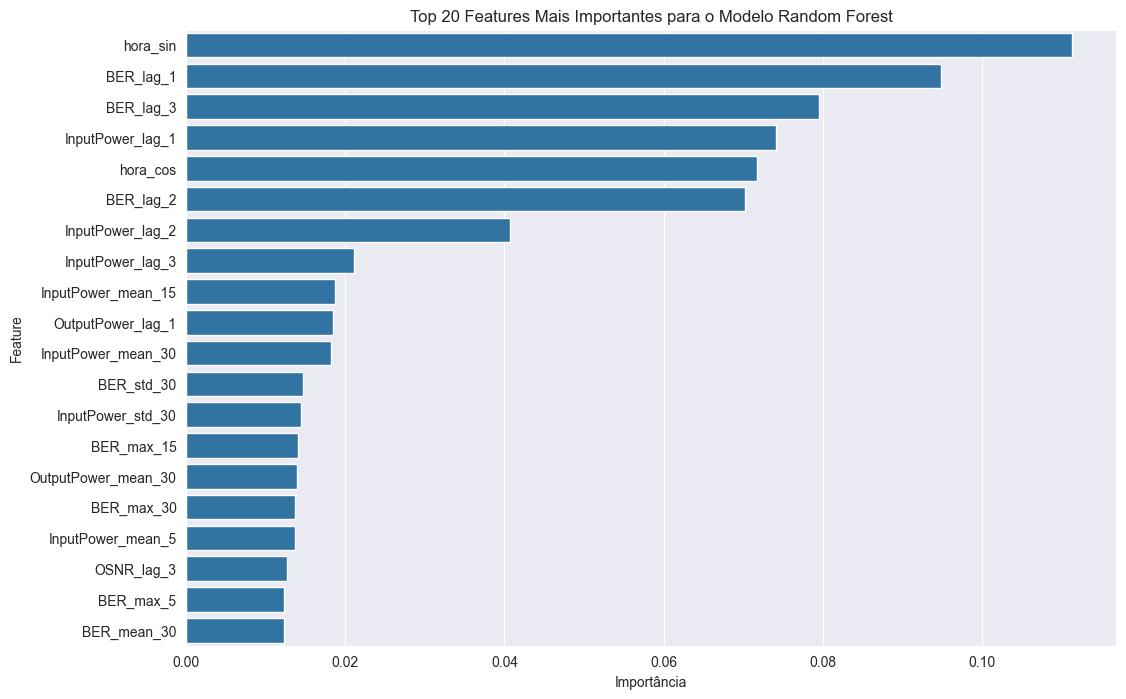

In [60]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features Mais Importantes para o Modelo Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()